<a href="https://colab.research.google.com/github/rathorebharat/mftracker/blob/main/mutual_fund_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# To install the mftool library
!pip install mftool==2.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mftool: filename=mftool-2.8-py3-none-any.whl size=116617 sha256=979e33567075a05a42dd01561e9e81b50ea0d0f05bb0b9b9d558d3454930fe9b
  Stored in directory: /root/.cache/pip/wheels/b6/b3/af/5751d41db5452227e221aaca7f1ec823caa51ae7d40fb9dbde
Successfully built mftool


In [2]:
!pip install nsepy==0.8

  Preparing metadata (setup.py) ... done
  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36056 sha256=2d3b2d57cb95c0999f47ae72ba24a326eb08c03bc131410d3b0dd3a01d30b98a
  Stored in directory: /root/.cache/pip/wheels/4c/87/cb/acaf83f625e5fc73e1fe6e2a8e97680c74cd72391850ef5a86
Successfully built nsepy


127073;INF336L01HC7;-;HSBC Asia Pacific (Ex Japan) Dividend Yield Fund - Growth;22.6977;08-Nov-2024
127071;INF336L01HF0;-;HSBC Asia Pacific (Ex Japan) Dividend Yield Fund - Growth Direct;24.4354;08-Nov-2024
127072;INF336L01HG8;INF336L01HH6;HSBC Asia Pacific IDCW Yield Fund Direct Plan IDCW;18.8275;08-Nov-2024
127070;INF336L01HD5;INF336L01HE3;HSBC Asia Pacific IDCW Yield Fund IDCW;18.9628;08-Nov-2024
Nifty 50
Small Cap HD
Midcap MO
Opportunities PG
Gold FoF
China FoF Ed
NYSE FoF MA
Gobal AX
Global DS
Global KO
Japan NI
Asia w/o Japan HS
Oppurtunity DS
Pharma AB
Finance MA


[]

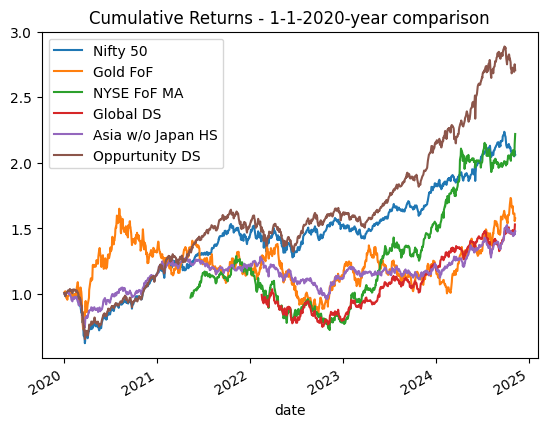

In [15]:
# https://medium.com/@TejasEkawade/getting-and-analyzing-mutual-funds-in-python-c2d0feb09881

# List of all mutual funds and their latest NAV
# https://www.amfiindia.com/spages/NAVAll.txt
# 148725;INF204KB19Z5;INF204KC1014;NIPPON INDIA NIFTY MIDCAP 150 INDEX FUND - DIRECT Plan - IDCW Option;25.3024;30-Aug-2024
# 138528;INF223J01NF2;-;PGIM India Global Equity Opportunities Fund - Direct Plan - Growth;47.78;30-Aug-2024
# 127042;INF247L01445;-;Motilal Oswal Midcap Fund-Direct Plan-Growth Option;115.7794;30-Aug-2024

import requests
search_string = 'HSBC Asia Pacific'  # Replace with the string to search for
url = 'https://www.amfiindia.com/spages/NAVAll.txt'  # Replace with the actual URL
response = requests.get(url)
page_content = response.text
for line in page_content.splitlines():
    if search_string in line:
        print(line)

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from mftool import Mftool

mf = Mftool()
# result = mf.get_available_schemes('hdfc')
# for scheme_code, scheme in result.items():
#     print(scheme_code, scheme)

# Mutual Funds Analysis — Implementation
# Part 1: Tabular Representation
# Let’s pull data for multiple funds and save them as dataframes. These data frames will be saved in a dictionary.

end_date = datetime.date.today()

def fetch_mutual_fund_data(mutual_fund_code):
    mf = Mftool()

    df = (mf.get_scheme_historical_nav(mutual_fund_code,as_Dataframe=True).reset_index()\
          .assign(nav=lambda x: x['nav'].astype(float),
                 date=lambda x: pd.to_datetime(x['date'], format='%d-%m-%Y'))\
          .sort_values('date')\
          .reset_index(drop=True)\
         )

    return df

# Fetch data for these funds
mutual_funds = {
    '119063': 'Nifty 50',
    '130503': 'Small Cap HD',
    '127042': 'Midcap MO',
    '125307': 'Opportunities PG',
    '119277': 'Gold FoF',
    '140243': 'China FoF Ed',
    #'145552': 'USA FoF MO',
    '148928':'NYSE FoF MA',
    '148954': 'Gobal AX',
    '149816': 'Global DS',
    '149059': 'Global KO',
    '130860': 'Japan NI',
    '127071': 'Asia w/o Japan HS',
    '119218': 'Oppurtunity DS',
    '147409': 'Pharma AB',
    '148623': 'Finance MA'

}

mf_data_dict = dict()

for mutual_fund_code, mutual_fund_desc in mutual_funds.items():
    print(mutual_fund_desc)
    mf_data_dict[mutual_fund_desc] = fetch_mutual_fund_data(mutual_fund_code)
# Next, create a function that computes the cumulative returns and CAGR. We are going to do this for 1 year, 2 years, and 3 years.

def get_cumulative_returns(df,
                         nav_col='CLOSE',
                         date_col='date',
                         starting_date='1-1-2019',
                         ending_date = end_date):
    start_date = pd.to_datetime(starting_date, format='%d-%m-%Y')
    end_date = pd.to_datetime(ending_date, format='%d-%m-%Y')

    df = (df\
          .sort_values(date_col)\
          .query(f"{date_col} >= @start_date and {date_col} <=@end_date")\
          .assign(daily_returns=lambda x: x[nav_col].pct_change(),
                  cumulative_daily_returns=lambda x: (x['daily_returns'] + 1).cumprod())\
          .reset_index(drop=True)\
         )

    return df

# We now pass our data — mutual funds and benchmark index — through the function to calculate metrics.

time_periods = {
    1: '1-1-2024',
    2: '1-1-2023',
    3: '1-1-2022',
    4: '1-1-2021',
    5: '1-1-2020'
}
results = []
time_period_dataframes = {time_period: dict() for time_period in time_periods}

# Index data
# from nsepy import get_history
#from dateutil.relativedelta import relativedelta

# n_years = 3 # Parameter for historical years

# def convert_to_date(date_str):
#    date_obj = datetime.datetime.strptime(date_str, '%d %b %Y')
#    return date_obj

# Get from and to dates
# start_date = datetime.datetime.strptime('1-1-2021', '%d-%m-%Y').date()
# print(from_date, end_date)

# Fetch the index data
# raw_index_data = get_history(symbol="NIFTY MIDCAP 150", start=start_date, end=end_date, index=True)

# Converting into dataframe and processing the data
# nifty_midcap_150 = (pd.DataFrame(raw_index_data)\
#                            .assign(HistoricalDate=lambda x: x['HistoricalDate'].apply(convert_to_date),
#                                    CLOSE=lambda x: x['CLOSE'].astype(float))\
#                            .sort_values('HistoricalDate')\
#                            .drop_duplicates()\
#                            .loc[lambda x: x['Index Name'] == 'NIFTY MIDCAP 150']\
#                            .reset_index(drop=True)\
#                            .rename(columns={'HistoricalDate':'date'})
#                   )

# for time_period, starting_date in time_periods.items():
#    n_years = time_period
#    nifty_midcap_cumulative = get_cumulative_returns(nifty_midcap_150,
#                                                           nav_col='CLOSE',
#                                                           date_col='date',
#                                                           starting_date=starting_date,
#                                                           ending_date ='31-12-2023')
#    nifty_midcap_cumulative = nifty_midcap_cumulative.rename(columns={'Date':'date'})
#    absolute_returns_prcnt = (nifty_midcap_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
#    cagr = ((nifty_midcap_cumulative['CLOSE'].iloc[-1]/nifty_midcap_cumulative['CLOSE'].iloc[0]) ** (1/n_years) - 1) * 100
#
#    time_period_dataframes[time_period][nifty_midcap_150] = nifty_midcap_cumulative
#    results += [(nifty_midcap_150, time_period, absolute_returns_prcnt, cagr)]


# Mutual Funds data
mutual_funds_subset = [
    'Nifty 50',
    #'Small Cap HD',
    #'Midcap MO',
    #'Opportunities PG',
    'Gold FoF',
    #'China FoF Ed',
    'NYSE FoF MA',
    #'Gobal AX',
    'Global DS',
    #'Global KO',
    #'Japan NI',
    'Asia w/o Japan HS',
    'Oppurtunity DS',
    #'Pharma AB',
    #'Finance MA'
]

for instrument_desc in mutual_funds_subset:
    for time_period, starting_date in time_periods.items():
        n_years = time_period
        mutual_fund_data = mf_data_dict[instrument_desc].copy(deep=True)
        # print (mutual_fund_data)
        mf_with_cumulative = get_cumulative_returns(mutual_fund_data,
                                                           nav_col='nav',
                                                           date_col='date',
                                                           starting_date=starting_date,
                                                           ending_date = end_date)
        absolute_returns_prcnt = (mf_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
        cagr = ((mf_with_cumulative['nav'].iloc[-1]/mf_with_cumulative['nav'].iloc[0]) ** (1/n_years) - 1) * 100

        time_period_dataframes[time_period][instrument_desc] = mf_with_cumulative
        results += [(instrument_desc, time_period, absolute_returns_prcnt, cagr)]

# The results will be converted into a data frame.

result_df = pd.DataFrame(results, columns=['Fund', 'Years', 'Abs_returns_prcnt', 'CAGR']).\
pivot(index='Fund', columns='Years', values=['Abs_returns_prcnt', 'CAGR'])
result_df.columns = [f'{x}_{y}' for x, y in result_df.columns]
result_df = result_df.map(lambda x: f"{x:.2f}%")

time_period = 5

for idx, (instrument_desc, instrument_data) in enumerate(time_period_dataframes[time_period].items()):
    if idx == 0:
        ax = instrument_data.plot(y='cumulative_daily_returns', x='date', label=instrument_desc)
    else:
        instrument_data.plot(ax = ax, y='cumulative_daily_returns', x='date', label=instrument_desc)

plt.title(f"Cumulative Returns - {time_periods[time_period]}-year comparison")
ax.legend(loc='upper left')
plt.plot()